In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
df = pd.read_csv('../input/data.csv')
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

In [3]:
# the data is not sorted. The shot with id=1 is not the first shot chronologicaly
# calculate seconds_to_end = number of seconds left before the end of the period
df['seconds_to_end'] = (df['minutes_remaining'] * 60) + df['seconds_remaining']

# sort the dataframe by date, period ascendant and seconds_to_end descendant
df = df.sort_values(by=['game_date','period','seconds_to_end'], ascending=[True,True,False] )

df[['game_event_id','game_date','period','minutes_remaining','seconds_remaining','seconds_to_end']].head(20)

,game_event_id,game_date,period,minutes_remaining,seconds_remaining,seconds_to_end
22901,102,1996-11-03,1,0,42,42
22902,127,1996-11-05,2,10,8,608
22903,124,1996-11-06,2,8,37,517
22904,144,1996-11-06,2,6,34,394
22905,151,1996-11-06,2,5,27,327
22906,157,1996-11-08,2,7,18,438
22907,226,1996-11-08,2,2,16,136
22908,321,1996-11-08,3,3,25,205
22909,334,1996-11-08,3,1,53,113
22910,337,1996-11-08,3,1,14,74


## Data Cleaning

we first remove the columns we don't want

In [4]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id',
       'seconds_to_end'],
      dtype='object')

In [5]:
# lat,lon,loc_x and loc_y are correlated
df.drop(['lat','lon'], axis=1, inplace=True)

# we don't need game_id and game_event_id
df.drop(['game_id','game_event_id'], axis=1, inplace=True)

# Kobe has always played with the LA Lakers
df.drop(['team_id','team_name'], axis=1, inplace=True)

# we added the seconds to end of period
df.drop(['minutes_remaining','seconds_remaining'], axis=1, inplace=True)

In [6]:
df.columns

Index(['action_type', 'combined_shot_type', 'loc_x', 'loc_y', 'period',
       'playoffs', 'season', 'shot_distance', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_date',
       'matchup', 'opponent', 'shot_id', 'seconds_to_end'],
      dtype='object')

## Data Transformation
### Create new features

In [7]:
# make home/away feature from matchup
# if contains @, this is away game. home game otherwise
def home(row):
    try:
        row['matchup'].index('@')
        return 'away'
    except:
        return 'home'
        
df['venue'] = df.apply(home, axis = 1)

# we don't need matchup anymore because it's recurrent with opponent and tenure
df.drop('matchup', axis=1, inplace=True)

In [8]:
# add year and month and week day from game_date
df['year'] = pd.DatetimeIndex(df['game_date']).year
df['month'] = pd.DatetimeIndex(df['game_date']).month
df['weekday'] = pd.DatetimeIndex(df['game_date']).weekday
df.drop('game_date', axis=1, inplace=True)

In [9]:
# add some moving averages
periods = [10,20,50,100,200]

for n in periods:
    col = 'MA' + str(n)
    df[col] = df['shot_made_flag'].fillna(0.45).rolling(window=n).mean()
    #df[col] = pd.rolling_mean(df['shot_made_flag'],n)    

In [10]:
df[['MA10','MA20','MA50','MA100','MA200']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 22901 to 22900
Data columns (total 5 columns):
MA10     30688 non-null float64
MA20     30678 non-null float64
MA50     30648 non-null float64
MA100    30598 non-null float64
MA200    30498 non-null float64
dtypes: float64(5)
memory usage: 1.4 MB


In [11]:
df.columns

Index(['action_type', 'combined_shot_type', 'loc_x', 'loc_y', 'period',
       'playoffs', 'season', 'shot_distance', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent',
       'shot_id', 'seconds_to_end', 'venue', 'year', 'month', 'weekday',
       'MA10', 'MA20', 'MA50', 'MA100', 'MA200'],
      dtype='object')

In [12]:
# select the columns I'll keep
columns = ['action_type','loc_x','loc_y', 'period',
           'season','shot_made_flag','shot_id','seconds_to_end',
           'opponent','venue','MA10','MA20','MA50','MA100','MA200']

In [13]:
df = df[columns]

### Encode categorical variables

In [14]:
cat_cols = ['action_type','season','opponent','venue']

for col in cat_cols:
    dummies = pd.get_dummies(df[col], prefix=col)
    df.drop(col, axis=1, inplace=True)
    df = df.join(dummies)

In [15]:
df.columns.values[1::]

array(['loc_y', 'period', 'shot_made_flag', 'shot_id', 'seconds_to_end',
       'MA10', 'MA20', 'MA50', 'MA100', 'MA200',
       'action_type_Alley Oop Dunk Shot',
       'action_type_Alley Oop Layup shot',
       'action_type_Cutting Finger Roll Layup Shot',
       'action_type_Cutting Layup Shot', 'action_type_Driving Bank shot',
       'action_type_Driving Dunk Shot',
       'action_type_Driving Finger Roll Layup Shot',
       'action_type_Driving Finger Roll Shot',
       'action_type_Driving Floating Bank Jump Shot',
       'action_type_Driving Floating Jump Shot',
       'action_type_Driving Hook Shot', 'action_type_Driving Jump shot',
       'action_type_Driving Layup Shot',
       'action_type_Driving Reverse Layup Shot',
       'action_type_Driving Slam Dunk Shot', 'action_type_Dunk Shot',
       'action_type_Fadeaway Bank shot', 'action_type_Fadeaway Jump Shot',
       'action_type_Finger Roll Layup Shot',
       'action_type_Finger Roll Shot', 'action_type_Floating Jump shot

In [16]:
df.shape

(30697, 123)

## Features Selection

n 10 Important features(> 15 % of max importance):n ['loc_y' 'period' 'seconds_to_end' 'MA10' 'MA20' 'MA50' 'MA100' 'MA200'
 'action_type_Alley Oop Dunk Shot' 'action_type_Layup Shot']
nFeatures sorted by importance (DESC):n ['MA20' 'MA50' 'MA10' 'period' 'MA100' 'loc_y'
 'action_type_Alley Oop Dunk Shot' 'MA200' 'action_type_Layup Shot'
 'seconds_to_end']


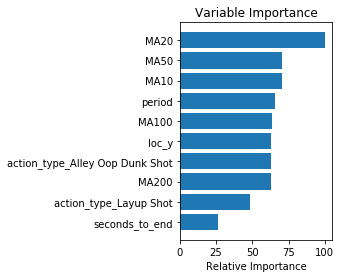

In [17]:
from sklearn.ensemble import RandomForestClassifier

df_feat = df
df_feat.dropna(subset=['MA200'], inplace=True)
df_feat.dropna(subset=['shot_made_flag'], inplace=True)

features_list = df_feat.drop(['shot_id','shot_made_flag'],axis=1).columns.values[1::]
#X = df_feat.values[:, 1::]
#y = df_feat.values[:, 0]

X = np.array(df_feat.drop(['shot_id','shot_made_flag'],axis=1))
y = np.array(df_feat['shot_made_flag'])

# Fit a random forest with (mostly) default parameters to determine feature importance
forest = RandomForestClassifier(oob_score=True, n_estimators=2000)
forest.fit(X, y)
feature_importance = forest.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 15

# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance > fi_threshold)[0]

# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]
print("n", important_features.shape[0], "Important features(>", fi_threshold, "% of max importance):n", 
        important_features)

# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
print("nFeatures sorted by importance (DESC):n", important_features[sorted_idx])

# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()

# Remove non-important features from the feature set, and reorder those remaining
X = X[:, important_idx][:, sorted_idx]

In [18]:
best_features = ['MA20','MA10','MA50','period','MA100','action_type_Alley Oop Dunk Shot',
                 'loc_y','MA200','action_type_Layup Shot','seconds_to_end']

## Parameters Optimization

In [ ]:
X_best = np.array(df_feat[best_features])

## make predictions


In [ ]:
gbc = GradientBoostingClassifier()

# We need an index to filter examples prior to the prediction.
# At this point, the dataframe is already sorted chronologically.
# We just need to reset the index
df.reset_index(inplace=True)

# There are some NaN in moving averages features.
# we replace them with 0.4 (the average success rate of kobe)
columns = ['MA10','MA20','MA50','MA100','MA200']

for col in columns:
    df[col].fillna(0.4, inplace=True)
    
# We now split the dataframe into a training set and a test set
df_train = df.dropna(subset=['shot_made_flag'])
df_test = df[df['shot_made_flag'].isnull()]

# We remove the shot_made_flag from the test set
# All values are NaN
df_test.drop(['shot_made_flag'],axis=1,inplace=True)

import csv
import warnings; warnings.simplefilter('ignore')

start = time.time()

i = 1
for index, row in df_test.iterrows():
        
    shot_id = df_test.get_value(index,'shot_id')
    
    print('Prediction # ' + str(i) + ', index = ' + str(index) + ', shot_id = ' + str(shot_id) + ', time = ' + str(time.time() - start))
    i += 1
    
    # create a subset to train the classifier
    train_subset = df_train[df_train.index < index]
    #X = np.array(train_subset.drop(['shot_id','shot_made_flag'], axis=1))
    X = np.array(train_subset[best_features])
    y = np.array(train_subset['shot_made_flag'])
    gbc.fit(X,y)
    
    # make a prediction for row
    X_test = np.array(df_test[best_features].loc[index])
    y_sub = gbc.predict_proba(X_test)    
    
    # save the prediction to a csv file    
    file = '../submissions/mod_20170206_02_gbc_optimized.csv'
    with open(file, 'a') as f:
        writer = csv.writer(f)
        # The second predicted value is the one we want
        # P(shot successful)
        writer.writerow([shot_id,y_sub[0][1]])
        
print('finished in ' + str(time.time() - start) + ' seconds.')

The submission got a score of **0.** ranking **/1117**